In [1]:
import tensorflow as tf
import edward as ed
import numpy as np
import seaborn as sns
import pandas as pd

from edward.models import Normal

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import skew, kurtosis
from sklearn.preprocessing import scale

%matplotlib inline
plt.style.use('seaborn')

In [2]:
TARGET = 'SalePrice'
NFOLDS = 5
SEED = 0
NROWS = None
SUBMISSION_FILE = '../input/sample_submission.csv'


## Load the data ##
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

ntrain = train.shape[0]
ntest = test.shape[0]

## Preprocessing ##

y_train = prices = np.log1p(train[TARGET])


train.drop([TARGET], axis=1, inplace=True)


all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))


#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data = pd.get_dummies(all_data)

#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

#creating matrices for sklearn:

x_train = np.array(all_data[:train.shape[0]])
x_test = np.array(all_data[train.shape[0]:])
N, D = x_train.shape
prices = np.float32(prices)
x_train = scale(x_train)
x_test = scale(x_test)

In [16]:
x = tf.placeholder(tf.float32, [None, D])

# The model is of the form mu = A + Bx
mn_offset = np.mean(prices, axis=0)
B = Normal(loc=tf.zeros(D), scale=tf.ones(D))
A = Normal(loc=mn_offset*tf.ones(1), scale=tf.ones(1))

# model
M_y = A + ed.dot(x, B)
y = Normal(loc=M_y, scale=tf.ones(1))

# approximate distributions
qB = Normal(
    loc=tf.Variable(tf.random_normal([D])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))

qA = Normal(
    loc=tf.Variable(mn_offset+tf.random_normal([1])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([1])))
)


In [17]:
latent_vars = {
    A: qA,
    B: qB
}

In [18]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)
tf.global_variables_initializer().run()

In [32]:
inference = ed.inferences.ReparameterizationKLKLqp(latent_vars, data={x: x_train, y: prices})
inference.run(n_samples=10, n_iter=2000)

2000/2000 [100%] ██████████████████████████████ Elapsed: 35s | Loss: 2411.517


In [58]:
def visualize_data_fit(X, y, B, A, title_prefix, n_samples=10):
    B_samples = B.sample(n_samples).eval()
    A_samples = A.sample(n_samples).eval()
    
    fig = plt.figure(figsize=(12, 9))
    ax = plt.axes(projection='3d')
    ax.scatter(X[:, 0], X[:, 1], y)
    plt.title(f'{title_prefix} Parameter Samples vs. Observed Data')
    
    inputs = np.linspace(-10, 10, num=500)
    for i in range(n_samples):
        output = inputs * B_samples[i][0] + inputs*B_samples[i][1]
        ax.plot(inputs, inputs, output)

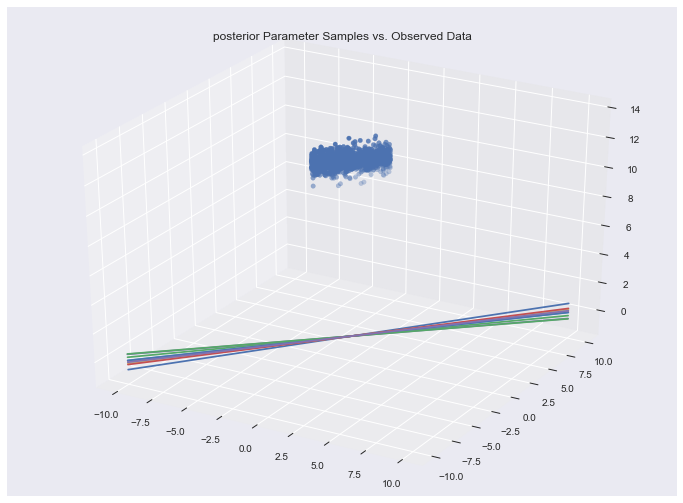

In [59]:
visualize_data_fit(X_train, prices, qB, qA, 'posterior', n_samples=10)

In [33]:
yp = ed.copy(y, latent_vars)

In [34]:
print(np.sqrt(ed.evaluate('mse', data={x: x_train, yp: (prices)})))

0.13483


In [29]:
aa = yp.sample(400).eval(feed_dict={x: x_train})

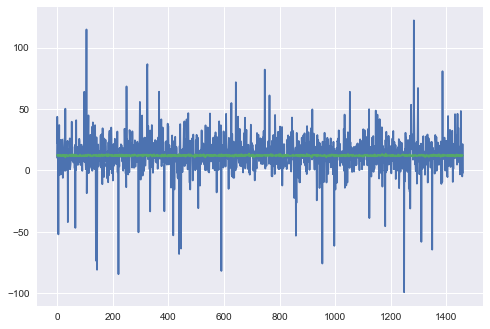

In [30]:
plt.plot(np.mean(aa, axis=0))
plt.plot(prices)

In [24]:
np.corrcoef(np.mean(aa, axis=0), prices)

array([[ 1.        ,  0.05804189],
       [ 0.05804189,  1.        ]])

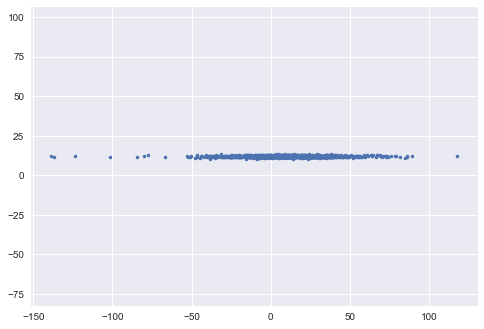

In [25]:
plt.plot(np.mean(aa, axis=0), prices ,'.')
plt.axis('equal')
q = np.linspace(8, 16, 40)
# plt.plot(q,q)

In [73]:
ed.inferences.ReparameterizationEntropyKLqp?

In [44]:
ed.dot(x, B)

<tf.Tensor 'Reshape_10:0' shape=(1460,) dtype=float32>

In [14]:
y_p = yp.sample(1000).eval(feed_dict={x: x_test})

InvalidArgumentError: Incompatible shapes: [1000,1460] vs. [1459]
	 [[Node: copied/Normal_2/sample_2/add = Add[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](copied/Normal_2/sample_2/mul, copied/Normal_2/loc)]]
	 [[Node: copied/Normal_2/sample_2/Reshape/_51 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_140_copied/Normal_2/sample_2/Reshape", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'copied/Normal_2/sample_2/add', defined at:
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-67f75b526dcc>", line 1, in <module>
    y_p = yp.sample(1000).eval(feed_dict={x: x_test})
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\ops\distributions\distribution.py", line 665, in sample
    return self._call_sample_n(sample_shape, seed, name)
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\ops\distributions\distribution.py", line 644, in _call_sample_n
    samples = self._sample_n(n, seed, **kwargs)
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\ops\distributions\normal.py", line 184, in _sample_n
    return sampled * self.scale + self.loc
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\ops\math_ops.py", line 894, in binary_op_wrapper
    return func(x, y, name=name)
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 182, in add
    "Add", x=x, y=y, name=name)
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Incompatible shapes: [1000,1460] vs. [1459]
	 [[Node: copied/Normal_2/sample_2/add = Add[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](copied/Normal_2/sample_2/mul, copied/Normal_2/loc)]]
	 [[Node: copied/Normal_2/sample_2/Reshape/_51 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_140_copied/Normal_2/sample_2/Reshape", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [15]:
# qq = yp.eval(feed_dict={x: X_train})
qq = np.log(np.mean(y_p, axis=0))
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(qq, np.log(prices))))
rmse.eval()

NameError: name 'y_p' is not defined

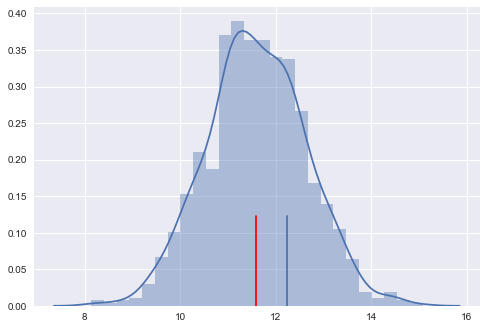

In [147]:
ind = 0
sns.distplot(y_p[:,ind])
plt.axvline(x=prices[ind], ymin=0, ymax=0.3)
plt.axvline(x=np.mean(y_p[:,ind],axis=0), ymin=0, ymax=0.3, color='r')

In [188]:
y_p.shape

(1000, 1459)

In [192]:
test_ID = test['Id']

sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = np.expm1(guess)
sub.to_csv('submission.csv',index=False)

In [167]:
guess = np.mean(y_p, axis=0)

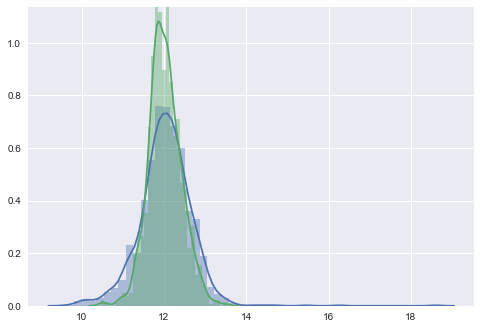

In [201]:
sns.distplot(guess)
sns.distplot(prices)

In [105]:
np.expm1(guess).shape

(1459,)

In [109]:
np.min(np.exp(guess))

0.00011763903

In [174]:
yy = ed.copy(M_y, latent_vars)

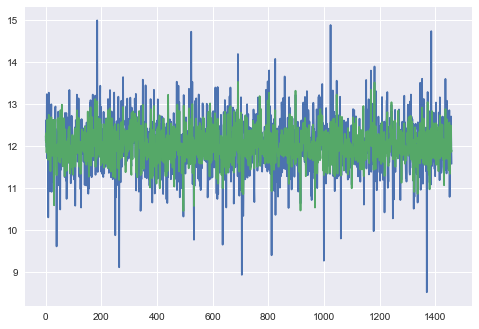

In [179]:
plt.plot(yy.eval(feed_dict={x: x_train}))
plt.plot(prices)

In [181]:
yL = []
for ind in range(1000):
    yL.append(yy.eval(feed_dict={x: x_test}))
    
    
guess = np.mean(yL, axis=0)

In [182]:
guess

array([ 11.2117157 ,  11.96401501,  12.11815453, ...,  12.11088181,
        11.77357483,  12.21467876], dtype=float32)

In [189]:
guess = np.mean(y_p, axis=0)

In [190]:
guess

array([ 11.5966444 ,  10.89976788,  11.85253429, ...,  12.1942358 ,
        11.92975807,  12.41803074], dtype=float32)

In [191]:
np.min(np.expm1(guess))

15327.619